## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [1]:
# !pip install wordcloud

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import pos_tag

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.feature_extraction.text import TfidfTransformer

pd.set_option('max_colwidth', 500)
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = "C:/Users/arpit/Desktop/UG/NLP/Automatic ticket Classification Assignment/complaints-2021-05-14_08_16.json"# Write the path to your data file and load it 

with open(f, 'r', encoding='utf-8') as f:
    data = json.load(f)

df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#Assign new column names
df["Complaints"]=df["_source.complaint_what_happened"]
len(df["Complaints"])



78313

In [7]:
df["Complaints"]= df["Complaints"].replace("",float('NaN'))

In [8]:
#Assign nan in place of blanks in the complaints column
df.fillna(np.nan,inplace=True)

In [9]:
#Remove all rows where complaints column is nan
df["Complaints"].isna().sum()

57241

In [10]:
df["Complaints"][3]

nan

In [11]:
df = df[df['Complaints'].notna()]

In [12]:
df.shape

(21072, 23)

In [13]:
#Checking for text within square brackets

sqbktpattern="\[.*?\]"

text =[]
for i in df["Complaints"]:
    if re.findall(sqbktpattern,i):
        text.append(re.findall(sqbktpattern,i))
        
print(text)

[['[ t ]', '[ Fico Scores, XXXX, XXXX and XXXX, respectively ]', '[ 1427 -3272.9 ]', '[ 1708 1725 ]', '[ cc and her supervisor, Mr. XXXX XXXX eventually, Executive Director, Mr. XXXX XXXX ]', '[ 8000 - 22980 ]', '[ 11000 - 15986 ]', '[ 1290012996 ]', '[ 12925-12928 ]', '[ 1 ]', '[ which we did ]', '[ 2 Trusted Agents of JP Morgan Chase ]'], ['[ any information they gave you about the debt ]'], ['[ to XXXX ]'], ['[ a ]', '[ 1 ]'], ['[ s ]'], ['[ 15 U.S.C. 1681s-2 ]'], ['[ XXXX XXXX XXXX ]', '[ I received no notice of this ]', '[ with a hold on it ]'], ['[ mortgage compan ies ]'], ['[ or written off when I die ]', '[ 5 ]', '[ See United States vs. The XXXX XXXX XXXX, Remission Administrator, for those details ]'], ['[ Chase ]', '[   Chase ]'], ['[ XXXX ]', '[ XXXX XXXX ]', '[ Assented to XX/XX/XXXX1964 ]', '[ Date Of Commencement : XX/XX/XXXX 1964 ]', '[ XXXX ]', '[ XXXX ]', '[ XXXX ]', '[ XXXX ]', '[ XXXX ]', '[ XXXX ]'], ['[   XXXX   ]', '[  XXXX  ]', '[ JpMorgan ]', '[ the banks ]'], 

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
sqbktpattern="\[.*?\]"

#Make the text lowercase
df["Complaints"]=df["Complaints"].map(str.lower)

#Remove text in square brackets
df["Complaints"]= df["Complaints"].str.replace(sqbktpattern," ")

In [15]:
#Checking for text within square brackets
text =[]
for i in df["Complaints"]:
    if re.findall(sqbktpattern,i):
        text.append(i)
        
print(text)

[]


In [16]:
#Remove punctuation
df["Complaints"]= df["Complaints"].str.replace(r'[^\w\s]+',"")

In [17]:
df["Complaints"][:5]

1                     good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help
2                                                                                                                                                               i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who wa

In [18]:
#Checking for words containing numbers

alphanum="\w*\d\w*"

text =[]
for i in df["Complaints"]:
    if re.findall(alphanum,i):
        text.append(re.findall(alphanum,i))
        
print(text)

[['2018'], ['xxxx2018'], ['xxxx2019'], ['xxxx2018', '30000', '10minutes', '10mins', 'xxxx2018', 'xxxx2018'], ['160000', '2', 'xxxx2018'], ['xxxx2019', 'xxxx2019', 'xxxx2019'], ['xxxx2019'], ['xxxx2019', '30000', 'xxxx2019'], ['xxxx2019'], ['10', '21'], ['2', '3400'], ['71000', 'xxxx2019', '4', '10', '24', '6300', '71000'], ['2500', '2500', '3', 'xxxx2019', 'xxxx2019'], ['240000'], ['40000'], ['xxxx2019', '3800', 'xxxx2019', 'xxxx2019', 'xxxx2019', 'xxxx2019', '3', '5', '2019'], ['1', '2', '3', '3', '3'], ['1700000'], ['100', '20000', '20000', '28000', '24000', '250000', '98000'], ['72'], ['26000', '16000', '26000', '14000', '23000', '21000', '690000', '720000', '38000', '2149'], ['750000', 'xxxx2018', '4', '5', '2', '3'], ['200000', '200000'], ['xxxx2018', '524', '524', '524', '524'], ['10feb', '11'], ['4300000', '10000000', 'xxxx2019', 'xxxx2019'], ['73000', 'xxxx2018', '17000', 'xxxx2018', '22000', 'xxxx2018', '15000', 'xxxx2018', '120000', '3rd'], ['30', 'xxxx2019', '25000', '30', '

In [19]:
#Remove words containing numbers
df["Complaints"]= df["Complaints"].str.replace(r'\w*\d\w*',"")

In [20]:
df["Complaints"][:5]

1                         good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help
2                                                                                                                                                                       i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who wa

In [21]:
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

#Function to lemmatize the text in a given column
def lemmatize_column(df, column):
    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        # Get the text in the given column
        text = row[column]
        # Lemmatize the text
        lemmatized_text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
        # Update the row with the lemmatized text
        df.at[index, "Lem_Complaints"] = lemmatized_text

# Use the function to lemmatize the "text" column in the DataFrame
lemmatize_column(df, "Complaints")

In [22]:
df_clean = df[["Complaints","Lem_Complaints"]]

In [23]:
df_clean

,Complaints,Lem_Complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check wa clear money wa taking by my chase bank refuse to pay me my money my grand son called chase time they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase
...,...,...
78303,after being a 

In [24]:
#removing all words except those with pos_tag NN

for index, row in df_clean.iterrows():
        # Get the text in the given column
        text = row["Lem_Complaints"]
        # Tokenize the text and add POS tags
        pos_tagged_text = pos_tag(text.split())
        # Lemmatize the nouns and keep only the nouns
        lemmatized_nouns = " ".join([word for word, pos in pos_tagged_text if pos == "NN" and word not in {'i'} and len(word)>2])
        # Update the row with the lemmatized nouns
        df_clean.at[index, "complaint_POS_removed"] = lemmatized_nouns

In [25]:
df_clean

,Complaints,Lem_Complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,card agent upgrade date agent information order account date xxxxxxxx consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...,book xxxx ticket offer ticket card information offer minute screen decision xxxx bank chase bank notification screen chase representative application state information xxxx offer credit offer account statement ticket glad account application representative application explicit request application chase chase fact credit account name credit report information credit report application consent error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was 

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [26]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len=[]
for i in df["Complaints"]:
    char_len.append(len(i))
    


In [27]:
char_len=pd.DataFrame(char_len,columns=['len'])

In [28]:
mask = char_len < 5000
filtered_data = char_len[mask]


filtered_data.value_counts()

len   
473.0     26
433.0     25
581.0     25
551.0     24
547.0     23
          ..
3160.0     1
3162.0     1
3163.0     1
3164.0     1
4998.0     1
Length: 3736, dtype: int64

(array([5207., 5887., 3790., 2251., 1303.,  767.,  572.,  621.,  161.,
         126.]),
 array([   0. ,  499.8,  999.6, 1499.4, 1999.2, 2499. , 2998.8, 3498.6,
        3998.4, 4498.2, 4998. ]),
 <BarContainer object of 10 artists>)

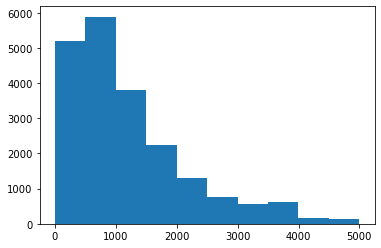

In [29]:
plt.hist(filtered_data,bins=10)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [30]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

corpus = df_clean["complaint_POS_removed"].tolist()

WordFreq = FreqDist(word_tokenize((" ").join(corpus))).most_common(40)
WordFreq

[('chase', 51080),
 ('account', 47647),
 ('xxxx', 38371),
 ('credit', 33094),
 ('card', 29587),
 ('bank', 28233),
 ('payment', 21167),
 ('time', 16038),
 ('day', 12972),
 ('xxxxxxxx', 12571),
 ('charge', 12237),
 ('money', 11961),
 ('loan', 10982),
 ('check', 10177),
 ('letter', 9669),
 ('information', 9654),
 ('fee', 8687),
 ('transaction', 8650),
 ('number', 8604),
 ('month', 8463),
 ('amount', 8363),
 ('year', 8292),
 ('mortgage', 8179),
 ('customer', 8163),
 ('balance', 7754),
 ('company', 7630),
 ('service', 7595),
 ('phone', 7589),
 ('report', 7215),
 ('fraud', 7115),
 ('claim', 7053),
 ('fund', 6980),
 ('call', 6926),
 ('business', 5593),
 ('interest', 5334),
 ('statement', 5268),
 ('home', 5266),
 ('issue', 5251),
 ('email', 5105),
 ('complaint', 5047)]

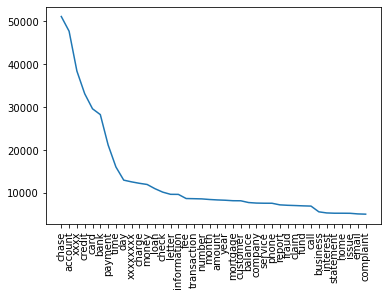

In [31]:
#Extract the x and y values from the tuples
x, y = zip(*WordFreq)

# Plot the x and y values
plt.plot(x, y)
plt.xticks(rotation=90)
plt.show()


In [32]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

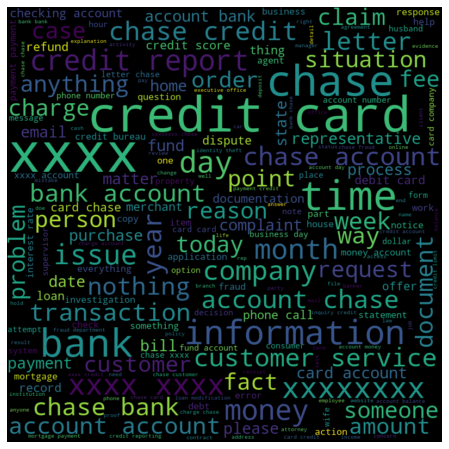

In [33]:
 
plt.figure(figsize=(8,8))
# Create a WordCloud object
wc = WordCloud(width = 800, height = 800,stopwords=stopwords, max_font_size = 100).generate(' '.join(corpus))

# Generate the word cloud

#wc.set_stopwords(stopwords)
# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [34]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

from nltk import ngrams

unigrams = []
for document in df_clean["complaint_POS_removed"]:
    unigrams.extend(ngrams(document.split(), 1))

print(pd.DataFrame(unigrams).value_counts()[:30])


chase          51080
account        47647
xxxx           38371
credit         33094
card           29587
bank           28233
payment        21167
time           16038
day            12972
xxxxxxxx       12571
charge         12237
money          11961
loan           10982
check          10177
letter          9669
information     9654
fee             8687
transaction     8650
number          8604
month           8463
amount          8363
year            8292
mortgage        8179
customer        8163
balance         7754
company         7630
service         7595
phone           7589
report          7215
fraud           7115
dtype: int64


In [35]:
#Print the top 10 words in the unigram frequency
pd.DataFrame(unigrams).value_counts()[:10]

chase       51080
account     47647
xxxx        38371
credit      33094
card        29587
bank        28233
payment     21167
time        16038
day         12972
xxxxxxxx    12571
dtype: int64

In [36]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

bigrams = []
for document in df_clean["complaint_POS_removed"]:
    bigrams.extend(ngrams(document.split(), 2))

print(pd.DataFrame(bigrams).value_counts()[:30])

0         1      
credit    card       12830
xxxx      xxxx        4202
credit    report      3878
chase     credit      3194
customer  service     3087
chase     account     3065
account   chase       2988
bank      account     2905
chase     bank        2854
account   account     2500
          bank        1742
card      account     1671
checking  account     1664
phone     call        1633
credit    score       1630
xxxx      chase       1569
debit     card        1561
account   xxxx        1521
card      chase       1512
account   credit      1493
money     account     1455
payment   payment     1338
credit    bureau      1297
interest  rate        1295
business  day         1265
phone     number      1246
xxxx      account     1244
account   number      1205
letter    chase       1183
card      card        1139
dtype: int64


In [37]:
#Print the top 10 words in the bigram frequency

pd.DataFrame(bigrams).value_counts()[:10]

0         1      
credit    card       12830
xxxx      xxxx        4202
credit    report      3878
chase     credit      3194
customer  service     3087
chase     account     3065
account   chase       2988
bank      account     2905
chase     bank        2854
account   account     2500
dtype: int64

In [38]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

trigrams = []
for document in df_clean["complaint_POS_removed"]:
    trigrams.extend(ngrams(document.split(), 3))

print(pd.DataFrame(trigrams).value_counts()[:30])

0         1           2             
chase     credit      card              2146
credit    card        account           1065
                      company            990
                      chase              709
inquiry   credit      report             523
credit    card        credit             499
xxxx      xxxx        xxxx               450
account   credit      card               427
card      credit      card               390
bank      credit      card               389
credit    reporting   agency             388
          card        bank               377
xxxx      credit      card               365
charge    credit      card               359
credit    report      credit             355
          reporting   act                329
account   credit      report             321
          chase       account            315
credit    card        xxxx               312
chase     customer    service            298
credit    card        payment            296
customer  service 

In [39]:
#Print the top 10 words in the trigram frequency
pd.DataFrame(trigrams).value_counts()[:10]

0        1       2      
chase    credit  card       2146
credit   card    account    1065
                 company     990
                 chase       709
inquiry  credit  report      523
credit   card    credit      499
xxxx     xxxx    xxxx        450
account  credit  card        427
card     credit  card        390
bank     credit  card        389
dtype: int64

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [40]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [41]:
#All masked texts has been removed
df_clean

,Complaints,Lem_Complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,card agent upgrade date agent information order account date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...,book ticket offer ticket card information offer minute screen decision bank chase bank notification screen chase representative application state information offer credit offer account statement ticket glad account application representative application explicit request application chase chase fact credit account name credit report information credit report application consent error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my 

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [42]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer()
documents = df_clean["complaint_POS_removed"].tolist()
documents[:5]

['morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help',
 'card agent upgrade date agent information order account date  consent  recording agent',
 'card application identity consent service credit identity applicant',
 'book  ticket offer ticket card information offer minute screen decision  bank chase bank notification screen chase representative application state information  offer credit offer account statement ticket glad account application representative application explicit request application chase chase fact credit account name credit report information credit report application consent error',
 'son deposit chase account fund chase bank account money son check money taking bank refuse money son time check owner country time date check number claim number chase']

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [43]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
# Extract the features from the documents
features = vectorizer.fit_transform(documents)
# Print the feature names
print(vectorizer.get_feature_names())

['___', '____', '_____', '_______', '________', '_________', '______________', '_________________', '_____________________________________________', '______________________________________________', '___________________________________________________________________________', '_behind', '_they_', 'aacount', 'aaid', 'aarp', 'aba', 'abandonment', 'abatement', 'abbreviation', 'abc', 'abd', 'aberration', 'abetting', 'abeyance', 'abide', 'ability', 'abillthe', 'abnormality', 'abou', 'about', 'above', 'abovewas', 'aboveyou', 'abrasive', 'abreast', 'abrupt', 'absence', 'absent', 'absentee', 'absentia', 'absolute', 'absolutley', 'absolve', 'absorb', 'absurd', 'absurdity', 'abundance', 'abuse', 'abuser', 'abusive', 'abusiveness', 'aca', 'academy', 'acc', 'accap', 'acccess', 'acccount', 'acceleration', 'accelerator', 'accent', 'accept', 'acceptance', 'acceptancecounteroffer', 'accepting', 'access', 'accessi', 'accessibility', 'accessory', 'accident', 'accidental', 'acciunt', 'acclaim', 'acco', 

In [44]:
# Print the vectors
dtm = pd.DataFrame(features.toarray(),columns=vectorizer.get_feature_names())

In [45]:
dtm

,___,____,_____,_______,________,_________,______________,_________________,_____________________________________________,______________________________________________,...,zerofraud,zeroliability,zilch,zip,zipcode,zipcodeaddress,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [47]:
#Load your nmf_model with the n_components
num_topics = 15 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)


In [48]:
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix




len(vectorizer.get_feature_names())

15164

In [49]:
#Print the Top15 words for each of the topics
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,checking,fund,reason,deposit,branch,access,business,balance,activity,year,name,identity,number
Topic 2,card,credit,chase,year,purchase,point,limit,freedom,reason,month,reward,application,offer,service,debit
Topic 3,payment,month,day,time,amount,statement,auto,bill,date,error,chase,car,history,plan,pay
Topic 4,inquiry,report,jpmcb,authorization,application,verification,proof,organization,date,knowledge,method,alert,company,section,credit
Topic 5,loan,modification,rate,home,auto,car,student,chase,application,document,lender,year,income,process,time
Topic 6,check,fund,deposit,day,hold,branch,chase,cash,amount,cashier,business,teller,week,customer,signature
Topic 7,chase,letter,number,call,phone,information,dispute,time,service,email,customer,complaint,day,address,response
Topic 8,fee,overdraft,year,time,customer,service,dollar,day,fund,month,bill,chase,deposit,transaction,practice
Topic 9,charge,dispute,merchant,fraud,company,amount,purchase,statement,chase,item,refund,vendor,investigation,billing,service
Topic 10,bank,fund,complaint,name,debit,wire,manager,customer,help,problem,security,cash,state,person,dollar


In [50]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

Topic_map = {1:"Credit card or prepaid card",
            4:"Mortgage/Loan",
            5:"Bank Account services",
            8:"Theft/Dispute Reporting",
            }

for i in range(15):
    if i in Topic_map.keys():
        continue
    else:
        Topic_map[i]="Others"

Topic_map

{1: 'Credit card or prepaid card',
 4: 'Mortgage/Loan',
 5: 'Bank Account services',
 8: 'Theft/Dispute Reporting',
 0: 'Others',
 2: 'Others',
 3: 'Others',
 6: 'Others',
 7: 'Others',
 9: 'Others',
 10: 'Others',
 11: 'Others',
 12: 'Others',
 13: 'Others',
 14: 'Others'}

In [51]:
W.argmax(axis=1)[:100]

array([ 9,  1,  1, 11,  5,  3,  0,  2, 12, 11,  0,  3,  0,  7,  1,  0, 14,
       14,  6,  8,  6, 11, 14,  4, 10,  6, 12,  1,  1,  6, 13,  8,  4,  2,
       11, 11,  6, 12,  1,  6,  1,  4, 11, 14,  6,  6,  5,  4,  1,  6,  6,
        9,  5,  0,  3,  9, 11, 12,  0, 11,  1,  0,  0,  3, 11,  5,  0,  4,
       12, 12,  8,  3, 14,  2, 11, 11, 14, 12,  5, 12,  8,  9,  6, 11,  3,
        8,  7,  6,  1,  4,  9, 14, 14, 13,  0,  8,  5,  1,  9,  1],
      dtype=int64)

In [52]:
print(Topic_map.get("2"))

None


In [53]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = W.argmax(axis=1)
#df_clean['Topic'] = df_clean.apply(lambda x: Topic_map.get(str(x)) if Topic_map.get(str(x)) else "Others") #write your code to assign topics to each rows.
df_clean.replace({"Topic":Topic_map},inplace=True)


In [54]:
df_clean.head(10)

,Complaints,Lem_Complaints,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,Others
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,card agent upgrade date agent information order account date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...,book ticket offer ticket card information offer minute screen decision bank chase bank notification screen chase representative application state information offer credit offer account statement ticket glad account application representative application explicit request application chase chase fact credit account name credit report information credit report application consent error,Others
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said 

In [55]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,Complaints,Lem_Complaints,complaint_POS_removed,Topic
176,i deposited a check that was endorsed to two parties and was told i needed verification of the funds once verification was received my account was still closed and i was told my accounts remaining balance would be mailed to me one check for the balance and another for the held funds of i was informed it would take business days from i received the funds two weeks later for an amount of xxxx but i never received my check for xxxx i have called once more to inquire and was told they could n...,i deposited a check that wa endorsed to two party and wa told i needed verification of the fund once verification wa received my account wa still closed and i wa told my account remaining balance would be mailed to me one check for the balance and another for the held fund of i wa informed it would take business day from i received the fund two week later for an amount of xxxx but i never received my check for xxxx i have called once more to inquire and wa told they could not see that accoun...,check party verification fund account account balance check balance held fund business day fund week amount check told account note account closure problem receipt deposit well money forth bank month mail everything fund hardship money loan dti home hardship account amount money,Bank Account services
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check wa clear money wa taking by my chase bank refuse to pay me my money my grand son called chase time they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,son deposit chase account fund chase bank account money son check money taking bank refuse money son time check owner country time date check number claim number chase,Bank Account services
154,on xxxxxxxx our firm issued a check in the amount of drawn on our chase checking account for xxxx s rent it was payable to xxxx xxxx xxxx on or about xxxxxxxx i received a telephone call from xxxx xxxx xxxx paying bank questioning intended payee they acknowledged that the check was payable to xxxx xxxx xxxx but had been endorsed by and deposited into an individual s account xxxx recommended that we contact chase s fraud department which i promptly did to request credit to our account ...,on xxxxxxxx our firm issued a check in the amount of drawn on our chase checking account for xxxx s rent it wa payable to xxxx xxxx xxxx on or about xxxxxxxx i received a telephone call from xxxx xxxx xxxx paying bank questioning intended payee they acknowledged that the check wa payable to xxxx xxxx xxxx but had been endorsed by and deposited into an individual s account xxxx recommended that we contact chase s fraud department which i promptly did to request credit to our account for this ...,firm check amount drawn chase account rent telephone call bank payee check account fraud department credit account check time landlord rent check chase check account check payee bank credit account process claim claim form chase week date chase form chase day bank chase violation ucc deposit agreement chase check endorsement endorsement fact chase position firm cost profitability business risk endorsement basis complaint respect day account spite fact policy variant ucc deposit contract,Bank Account services
133,on i made a deposit into my cha

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [56]:
#Create the dictionary of Topic names and Topics

Topic_names = {'Others':0, 'Bank Account services':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean.replace({"Topic":Topic_names},inplace=True)

In [57]:
df_clean

,Complaints,Lem_Complaints,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,card agent upgrade date agent information order account date consent recording agent,3
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my ...,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application...,book ticket offer ticket card information offer minute screen decision bank chase bank notification screen chase representative application state information offer credit offer account statement ticket glad account application representative application explicit request application chase chase fact credit account name credit report information credit report application consent error,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean.drop(['Lem_Complaints', 'complaint_POS_removed'], axis=1)

In [59]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.Complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [61]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report




In [62]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [63]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2972
           1       0.94      0.79      0.86       280
           2       0.94      0.72      0.82       221
           3       0.87      0.73      0.79       477
           4       0.90      0.65      0.76       265

    accuracy                           0.90      4215
   macro avg       0.91      0.77      0.83      4215
weighted avg       0.90      0.90      0.89      4215



In [660]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2972
           1       0.86      0.84      0.85       280
           2       0.75      0.78      0.77       221
           3       0.72      0.73      0.72       477
           4       0.64      0.68      0.66       265

    accuracy                           0.86      4215
   macro avg       0.77      0.79      0.78      4215
weighted avg       0.86      0.86      0.86      4215



In [661]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2972
           1       0.00      0.00      0.00       280
           2       0.00      0.00      0.00       221
           3       0.00      0.00      0.00       477
           4       0.00      0.00      0.00       265

    accuracy                           0.71      4215
   macro avg       0.14      0.20      0.17      4215
weighted avg       0.50      0.71      0.58      4215



## Conclusion : Logistic Regression with 90% accuracy is the best performer among the three models